In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
from glob import glob
sys.path.append('../../')
from modules.basics import *
from typing import *

In [2]:
NAME = '17_hyperparam_search'
MACHINE = 'mbp'

In [3]:
if (RESULTS_PATH/f'{NAME}_{MACHINE}.json').is_file():
    print('Loading existing results')
    experiment = Experiment.from_json(RESULTS_PATH/f'{NAME}_{MACHINE}.json')
else:
    experiment = Experiment(NAME, MACHINE, RESULTS_PATH)
    experiment['params'] = []
    experiment['scores'] = []
    experiment.save()

Loading existing results


In [4]:
!python ../../modules/data_import.py -d ../../data/ -f PRI_jet_num -s 6666

Converting to use_cartesian coordinates
Converting to use_cartesian coordinates
Training on 200000 datapoints and validating on 50000, using 31 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_pt']
Saving fold 0 with 20003 events
Saving fold 1 with 20003 events
Saving fold 2 with 20003 events
Saving fold 3 with 20003 events
Saving fold 4 with 20002 events
Saving fold 5 with 20001 events
Saving fold 6 with 19999 events
Saving fold 7 with 19996 events
Saving 

## Training

### Options

In [5]:
train_fy = HEPAugFoldYielder(DATA_PATH/'train.hdf5', rot_mult=2)
val_fy   = HEPAugFoldYielder(DATA_PATH/'val.hdf5',   rot_mult=2)
test_fy  = HEPAugFoldYielder(DATA_PATH/'test.hdf5',  rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [6]:
n_models = 3
patience = 50
max_epochs = 15
bs = 256

In [7]:
def get_model_builder(params:Dict[str,Union[int,float]]) -> ModelBuilder:
    body = partial(FullyConnected, depth=params['depth'], width=params['width'], act='swish',
                   dense=True, growth_rate=params['growth_rate'], do=params['do'])
    cat_embedder = CatEmbedder.from_fy(train_fy, emb_szs=[3])
    opt_args = {'opt':'Adam', 'eps':1e-8, 'weight_decay':params['wd']}
    return ModelBuilder(objective='classification', cont_feats=train_fy.cont_feats, n_out=1, cat_embedder=cat_embedder,
                        opt_args=opt_args, body=body)

In [8]:
def train_model(fy:FoldYielder, model_builder:ModelBuilder, callback_partials:Optional[List[partial]],
                patience:int, max_epochs:int, n_models:int=10, bs:int=256,) -> List[Dict[str,float]]:
    results, histories, cycle_losses = fold_train_ensemble(fy, n_models,
                                                           model_builder=model_builder,
                                                           bs=bs,
                                                           callback_partials=callback_partials,
                                                           max_epochs=max_epochs, patience=patience,
                                                           plots=[], verbose=False)
    return results

In [9]:
def score_params(results:List[Dict[str,float]], model_builder:ModelBuilder, n_models:int,
                 val_fy:FoldYielder, test_fy:FoldYielder,
                 ams_args:Dict[str,float]={'top_perc':10, 'br':10, 'wgt_factor':250000/50000}) -> Dict[str,float]:
    scores = {}
    ensemble = Ensemble.from_results(results, n_models, model_builder)
    ensemble.predict(val_fy)
    cut, scores['val'], _ = binary_class_cut_by_ams(val_fy.get_df(), **ams_args)
    ensemble.predict(test_fy)
    scores['test'], _ = score_test_data_per_fold(test_fy, cut)
    return scores

In [10]:
def get_params() -> Dict[str,Any]:
    params = {}
    params['depth']       = np.random.randint(2,9)
    params['width']       = np.random.randint(33,101)
    params['growth_rate'] = np.random.uniform(-0.2,1)
    params['wd']    = float((1e-5)*np.random.choice([0,1e-2,1e-3,1e-4,1e-5,1e-6], 1)[0])
    params['do']    = float(np.random.choice([0,0.05,0.1,0.25,0.5], 1)[0])
    return params

In [11]:
def run_experiment(experiment:Experiment, max_epochs:int, n_models:int, bs:int, patience:int) -> None:
    n_params, body_width = math.inf,-math.inf
    while n_params > 100000 or n_params < 5000 or body_width <= 1:
        params = get_params()
        model_builder = get_model_builder(params)
        m = Model(model_builder)
        n_params = m.get_param_count()
        body_width = m.body.get_out_size()
    callback_partials = [partial(OneCycle, lengths=(45, 90), lr_range=[1e-4, 1e-2], mom_range=(0.85, 0.95), interp='cosine')]
    print(params, n_params, body_width)
    results = train_model(fy=train_fy, model_builder=model_builder, callback_partials=callback_partials, patience=patience,
                          max_epochs=max_epochs, n_models=n_models, bs=bs)
    score = score_params(results, model_builder, n_models, val_fy, test_fy)
    experiment['scores'].append(score)
    experiment['params'].append(params)
    experiment.save()

In [12]:
experiment

Experiment:	17_hyperparam_search
Machine:	mbp
Device:	Intel Core i7-8559U CPU @ 2.7 GHz (4x2)
params	[{'depth': 3, 'width': 45, 'growth_rate': 0.6640794721039245, 'wd': 0.0, 'do': 0.25}]
scores	[{'val': 3.5077060739605166, 'test': [3.6736365380806335, 0.08467566513898528]}]

In [13]:
experiment.save()



Experiment 0______________________________________
{'depth': 2, 'width': 99, 'growth_rate': -0.032911981134699314, 'wd': 1e-08, 'do': 0.25} 16243 96


Training model 1 / 3, Val ID = 0


Early stopping after 135 epochs
Scores are: {'loss': 3.41909731105261e-06}
Fold took 69.261s

Training model 2 / 3, Val ID = 1


Early stopping after 135 epochs
Scores are: {'loss': 3.4296608646400273e-06}
Fold took 70.021s

Training model 3 / 3, Val ID = 2


Early stopping after 135 epochs
Scores are: {'loss': 3.4516826872277306e-06}
Fold took 67.118s


______________________________________
Training finished
Cross-validation took 206.402s 
Mean loss = 3.433e-06±8e-09
______________________________________

Choosing ensemble by loss


Model 0 is 0 with loss = 3.41909731105261e-06
Model 1 is 1 with loss = 3.4296608646400273e-06
Model 2 is 2 with loss = 3.4516826872277306e-06


Mean time per event = 0.00012±3e-06
50000 datapoints loaded
Mean cut at 0.9295756816864014 corresponds to AMS of 3.0738396297390236
Maximum AMS for data is 3.1372721505775067 at cut of 0.9142276048660278


<Figure size 432x288 with 0 Axes>

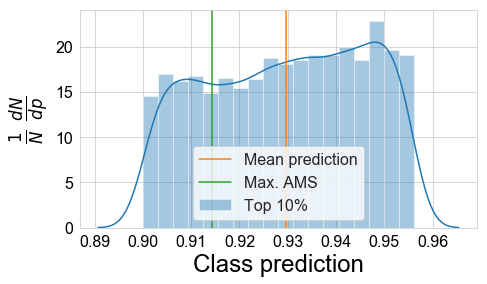

Mean time per event = 6.72e-05±2e-07
Mean Public:Private AMS: 3.3±0.09 : 3.22±0.03


Experiment 1______________________________________
{'depth': 2, 'width': 83, 'growth_rate': -0.15160059573416015, 'wd': 0.0, 'do': 0.0} 11213 71


Training model 1 / 3, Val ID = 0


KeyboardInterrupt: 

In [17]:
for i in range(30): 
    print(f'\n\nExperiment {i}______________________________________')
    run_experiment(experiment, max_epochs, n_models, bs, patience)